In [1]:
import os
import glob
import re
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.utils import to_categorical

from skimage import color
from skimage import io
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Preprocessing

In [2]:
home = os.path.expanduser('~')

In [3]:
image_dir = os.path.join(home, 'Downloads/abyssim')
mask_dir = os.path.join(home, 'Downloads/abyssmasks')

In [10]:
image_names = get_names(image_dir)
mask_names = get_names(mask_dir)

In [11]:
print(image_names[1])
print(mask_names[1])

Abyssinian_10.jpg
Abyssinian_10.png


In [5]:
# resizes images to desired dimensions
def resize(img, height=128, width=128):
    return cv2.resize(img, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

In [6]:
def get_names(path):
    home = os.path.expanduser('~')
    names = os.listdir(os.path.join(home, path))
    names.sort()
    
    return names

In [7]:
def get_images(height=128, width=128):
    
    home = os.path.expanduser('~')
    image_dir = os.path.join(home, 'Downloads/abyssim')
    
    image_names = get_names(image_dir)
    
    # array to hold images
    images = np.zeros((len(image_names), height, width, 1))
    
    # load iamges
    for i in range(len(image_names)):
        img_path = os.path.join(image_dir, image_names[i])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # resize
        img = cv2.resize(img, dsize=(height,width), interpolation=cv2.INTER_CUBIC)
        img = np.expand_dims(img, axis=2)
        
        # normalize
        img = img / 256
        
        images[i] = img
    
    return images

In [8]:
def get_masks(height=128, width=128):
    
    home = os.path.expanduser('~')
    mask_dir = os.path.join(home, 'Downloads/abyssmasks')
    
    mask_names = get_names(mask_dir)
    
    # array to hold masks
    masks = np.zeros((len(mask_names), height, width))
    
    # load masks
    for i in range(len(mask_names)):
        mask_path = os.path.join(mask_dir, mask_names[i])
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        # resize
        mask = resize(mask)
        
        # some individual masks have sparse number of 0 values; replace with 1
        mask = np.where(mask!=0, mask, 1)
        masks[i] = mask
    
    # encode masks
    labelencoder = LabelEncoder()
    n,h,w = masks.shape

    # flatten and encode
    masks_reshaped = masks.reshape(-1,1)
    masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
    masks_original_shape_encoded = masks_reshaped_encoded.reshape(n,h,w)
    
    masks_original_shape_encoded = np.expand_dims(masks_original_shape_encoded, axis=3)
    
    masks = to_categorical(masks_original_shape_encoded, num_classes=3)
    
    return masks

In [9]:
def split_data(images, masks, out_of_sample=0.1):
    # set aside out of sample data
    x_train_, x_test, y_train_, y_test = train_test_split(images, masks, test_size=out_of_sample, random_state=9, shuffle=False)
    
    # create training & validation set
    x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=0.1, random_state=9, shuffle=False)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [12]:
images = get_images()

In [16]:
masks = get_masks()

In [17]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(images, masks)

In [18]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

161 161
18 18
20 20


# Build Model

In [19]:
class UNet():
    def __init__(self, input_size=(128,128,1), n_classes=3, drop=0.1):
        self.input_size = input_size
        self.n_classes = n_classes
        self.drop = drop
        
        self.model = self.create_model()
        
    
    def create_model(self):
        inputs = Input(self.input_size)
        
        # down sampling
        c1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
        c1 = Dropout(self.drop)(c1)
        c1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
        p1 = MaxPooling2D(2)(c1)
        
        c2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
        c2 = Dropout(self.drop)(c2)
        c2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
        p2 = MaxPooling2D(2)(c2)
        
        c3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = Dropout(self.drop)(c3)
        c3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
        p3 = MaxPooling2D(2)(c3)
        
        c4 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = Dropout(self.drop)(c4)
        c4 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
        p4 = MaxPooling2D(2)(c4)
        
        c5 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
        c5 = Dropout(self.drop)(c5)
        c5 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
        
        # up sampling
        u6 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
        c6 = Dropout(self.drop)(c6)
        c6 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
        
        u7 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
        c7 = Dropout(self.drop)(c7)
        c7 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
        
        u8 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
        c8 = Dropout(self.drop)(c8)
        c8 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
        
        u9 = Conv2DTranspose(16, 2, strides=(2,2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        c9 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
        c9 = Dropout(self.drop)(c9)
        c9 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
        
        outputs = Conv2D(self.n_classes, 1, activation='softmax')(c9)
        model = Model(inputs=[inputs], outputs=[outputs])
        
        return model

# Train Model

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy()

In [22]:
unet = UNet()
model = unet.model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train,
                             batch_size=4,
                             epochs=20,
                             validation_data=(x_val, y_val),
                             shuffle=False)

Epoch 1/20


2022-03-26 21:37:00.244302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


41/41 [==============================] - 10s 69ms/step - loss: 1.0516 - accuracy: 0.5321 - val_loss: 0.9908 - val_accuracy: 0.6019
Epoch 2/20
41/41 [==============================] - 1s 18ms/step - loss: 0.9890 - accuracy: 0.5773 - val_loss: 0.9611 - val_accuracy: 0.6069
Epoch 3/20
41/41 [==============================] - 1s 18ms/step - loss: 0.9246 - accuracy: 0.5938 - val_loss: 0.8897 - val_accuracy: 0.6508
Epoch 4/20
41/41 [==============================] - 1s 18ms/step - loss: 0.8502 - accuracy: 0.6452 - val_loss: 0.8671 - val_accuracy: 0.6826
Epoch 5/20
41/41 [==============================] - 1s 20ms/step - loss: 0.8208 - accuracy: 0.6726 - val_loss: 0.8532 - val_accuracy: 0.6946
Epoch 6/20
41/41 [==============================] - 1s 20ms/step - loss: 0.8029 - accuracy: 0.6851 - val_loss: 0.8432 - val_accuracy: 0.6985
Epoch 7/20
41/41 [==============================] - 1s 20ms/step - loss: 0.7867 - accuracy: 0.6936 - val_loss: 0.8371 - val_accuracy: 0.6778
Epoch 8/20
41/41 [=====

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

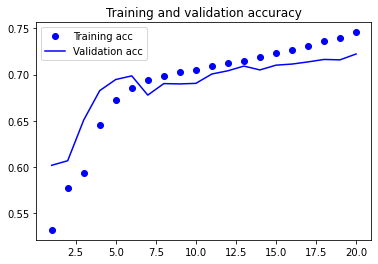

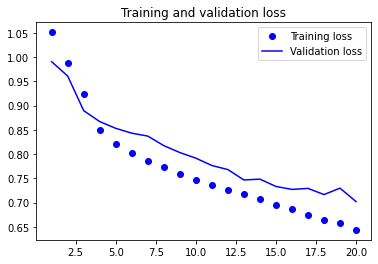

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
pred = model.predict(x_test)

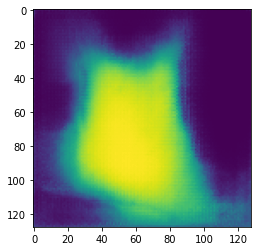

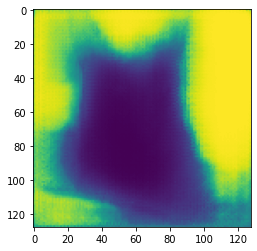

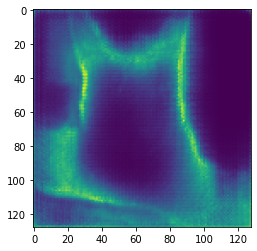

In [27]:
for i in range(3):
    plt.imshow(pred[0][:,:,i])
    plt.show()

In [28]:
len(np.unique(pred[0]))

49047

In [72]:
pred_argmax = np.argmax(pred, axis=3)

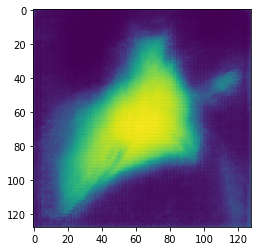

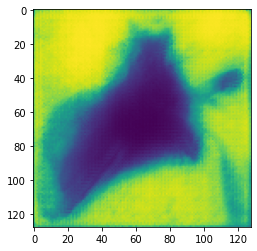

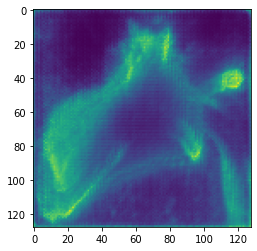

In [73]:
for i in range(3):
    plt.imshow(pred[7][:,:,i])
    plt.show()

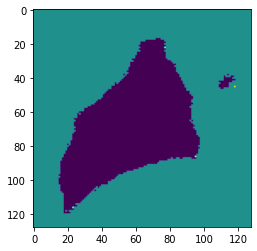

In [74]:
plt.imshow(pred_argmax[7])

In [65]:
np.unique(pred_argmax[0])

array([0, 1, 2])

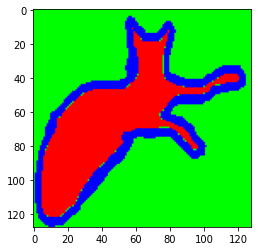

In [70]:
plt.imshow(y_test[7])

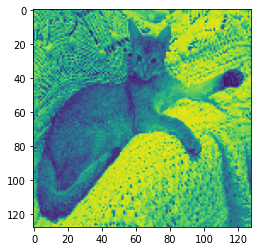

In [71]:
plt.imshow(x_test[7])